## Training a vision transformer on SVHN dataset

Now that we trained convolutional neural network on processed SVHN data, as a comparison we're gonna train Vision Transformer. We're gonna rely heavily on Keras' [example](https://keras.io/examples/vision/vit_small_ds/) of training Vision Transformer on small datasets.

Note: this notebook uses Keras3 with Tensorflow backend

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow" 
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
import keras
from PIL import Image
from keras import ops
from keras import layers
from keras.preprocessing.image import img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
# Setting seed for reproducibiltiy
SEED = 42
keras.utils.set_random_seed(SEED)

# 1. Load data
As in previous notebook, first we're gonna load all the training and validation data

In [3]:
# Load dataset for training
train_ds = keras.preprocessing.image_dataset_from_directory(
    'processed_data',
    image_size=(64, 64),
    batch_size=64,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='training',
    label_mode='int' # prepare labels for training
)

# Load dataset for training
val_ds = keras.preprocessing.image_dataset_from_directory(
    'processed_data',
    image_size=(64, 64),
    batch_size=64,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='validation',
    label_mode='int' # prepare labels for training
)

# Check class names
print(f"Classes: {train_ds.class_names}")

Found 22535 files belonging to 10 classes.
Using 18028 files for training.


I0000 00:00:1746687854.158730    1390 gpu_process_state.cc:208] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1746687854.159734    1390 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 22535 files belonging to 10 classes.
Using 4507 files for validation.
Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


# 2. Set training parameters

In [4]:
# DATA
BUFFER_SIZE = 512
BATCH_SIZE = 64
INPUT_SHAPE = (64, 64, 3)
NUM_CLASSES = len(train_ds.class_names)

# AUGMENTATION
IMAGE_SIZE = 64
PATCH_SIZE = 8
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

# OPTIMIZER
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001

# TRAINING
EPOCHS = 30

# ARCHITECTURE
LAYER_NORM_EPS = 1e-6
TRANSFORMER_LAYERS = 8
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]
MLP_HEAD_UNITS = [2048, 1024]

# 3. Set data augmentation pipeline
Before setting data augmentation, we will first compute mean and variance of our data. This will help us initialize the Normalization layer.

In [5]:
# Compute the mean and the variance of the training data for normalization.
def compute_dataset_stats(dataset, image_size=64):
    # Initialize variables
    sum_images = 0
    sum_squares = 0
    num_images = 0
    
    # Iterate through batches
    for images, _ in dataset.unbatch().batch(100):  # Process in manageable batches
        images = keras.ops.cast(images, dtype='float32') / 255.0  # Convert to float and normalize
        batch_size = keras.ops.shape(images)[0]
        sum_images += keras.ops.sum(images, axis=[0, 1, 2])
        sum_squares += keras.ops.sum(images**2, axis=[0, 1, 2])
        num_images += batch_size
    
    # Compute final statistics
    mean = sum_images.numpy() / (num_images * image_size * image_size)
    variance = (sum_squares.numpy() / (num_images * image_size * image_size)) - mean**2
    std = np.sqrt(variance)
    
    return mean, variance, std

In [6]:
# Compute stats on training data
train_mean, train_variance, train_std = compute_dataset_stats(train_ds)
print(f"Mean: {train_mean}")
print(f'Variance: {train_variance}')
print(f"Std: {train_std}")

Mean: [0.42848724 0.4301367  0.4505991 ]
Variance: [0.0420205  0.04292111 0.04222322]
Std: [0.20498902 0.2071741  0.20548289]


2025-05-08 09:04:51.307043: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Rescaling(1./255),  # First scale to [0,1]
        layers.Normalization(mean=train_mean, variance=train_variance),
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)

### Implement Shifted Patch Tokenization
In Vision Transformers, input images are divided into patches that are then flattened into a vector for processing. One way to improve feature extraction is to introduce spatial shifts before dividing the image into patches. This is known as Shifted Patch Tokenization and in this example we will use it to apply multiple diagonal shifts to the input image and then divide it into patches.

In [14]:
@keras.saving.register_keras_serializable()
class ShiftedPatchTokenization(layers.Layer):
    def __init__(
        self,
        image_size=IMAGE_SIZE,
        patch_size=PATCH_SIZE,
        num_patches=NUM_PATCHES,
        projection_dim=PROJECTION_DIM,
        vanilla=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.vanilla = vanilla  # Flag to swtich to vanilla patch extractor
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

    def crop_shift_pad(self, images, mode):
        # Build the diagonally shifted images
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch

        # Crop the shifted images and pad them
        crop = ops.image.crop_images(
            images,
            top_cropping=crop_height,
            left_cropping=crop_width,
            target_height=self.image_size - self.half_patch,
            target_width=self.image_size - self.half_patch,
        )
        shift_pad = ops.image.pad_images(
            crop,
            top_padding=shift_height,
            left_padding=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        if not self.vanilla:
            # Concat the shifted images with the original image
            images = ops.concatenate(
                [
                    images,
                    self.crop_shift_pad(images, mode="left-up"),
                    self.crop_shift_pad(images, mode="left-down"),
                    self.crop_shift_pad(images, mode="right-up"),
                    self.crop_shift_pad(images, mode="right-down"),
                ],
                axis=-1,
            )
        # Patchify the images and flatten it
        patches = ops.image.extract_patches(
            images=images,
            size=(self.patch_size, self.patch_size),
            strides=[1, self.patch_size, self.patch_size, 1],
            dilation_rate=1,
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        if not self.vanilla:
            # Layer normalize the flat patches and linearly project it
            tokens = self.layer_norm(flat_patches)
            tokens = self.projection(tokens)
        else:
            # Linearly project the flat patches
            tokens = self.projection(flat_patches)
        return (tokens, patches)

Visualize the patches on a random image

image_3294_2.png


/home/nikola/envs/tf2keras3/lib/python3.10/site-packages/keras/src/layers/layer.py:396: UserWarning: `build()` was called on layer 'shifted_patch_tokenization', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


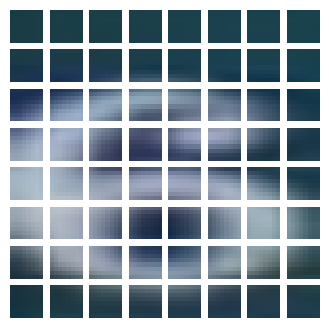

ORIGINAL


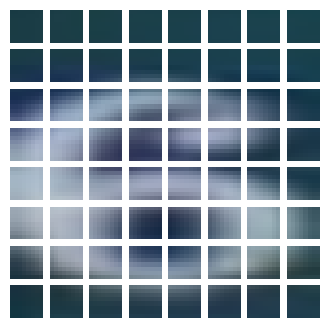

LEFT-UP


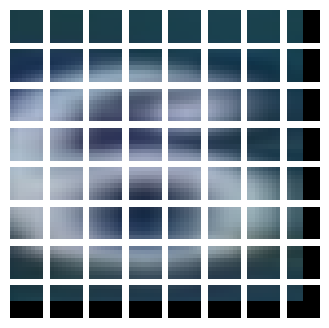

LEFT-DOWN


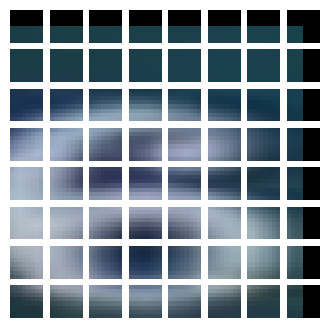

RIGHT-UP


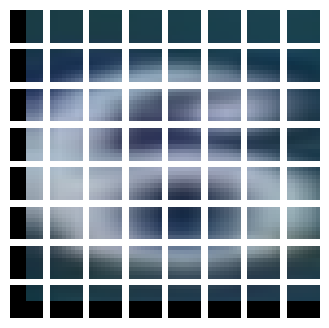

RIGHT-DOWN


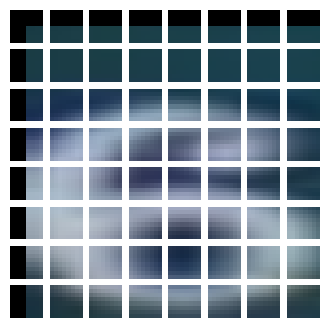

In [34]:
# Get a random image from the training dataset
# and resize the image
random_class = np.random.choice(train_ds.class_names)
random_image = random.choice(os.listdir(os.path.join('processed_data', random_class)))
print(random_image)
image = Image.open(os.path.join('processed_data', random_class, random_image))
np_image = np.array(image)
resized_image = ops.cast(
    ops.image.resize(ops.convert_to_tensor([img_to_array(np_image)]), size=(IMAGE_SIZE, IMAGE_SIZE)),
    dtype="float32",
)

# Vanilla patch maker: This takes an image and divides into
# patches as in the original ViT paper
(token, patch) = ShiftedPatchTokenization(vanilla=True)(resized_image / 255.0)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]
count = 1
plt.figure(figsize=(4, 4))
for row in range(n):
    for col in range(n):
        plt.subplot(n, n, count)
        count = count + 1
        image = ops.reshape(patch[row][col], (PATCH_SIZE, PATCH_SIZE, 3))
        plt.imshow(image)
        plt.axis("off")
plt.show()

# Shifted Patch Tokenization: This layer takes the image, shifts it
# diagonally and then extracts patches from the concatinated images
(token, patch) = ShiftedPatchTokenization(vanilla=False)(resized_image / 255.0)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]
shifted_images = ["ORIGINAL", "LEFT-UP", "LEFT-DOWN", "RIGHT-UP", "RIGHT-DOWN"]
for index, name in enumerate(shifted_images):
    print(name)
    count = 1
    plt.figure(figsize=(4, 4))
    for row in range(n):
        for col in range(n):
            plt.subplot(n, n, count)
            count = count + 1
            image = ops.reshape(patch[row][col], (PATCH_SIZE, PATCH_SIZE, 5 * 3))
            plt.imshow(image[..., 3 * index : 3 * index + 3])
            plt.axis("off")
    plt.show()

# 3. Define transformer
Implement the patch encoding layer

In [9]:
@keras.saving.register_keras_serializable()
class PatchEncoder(layers.Layer):
    def __init__(
        self, num_patches=NUM_PATCHES, projection_dim=PROJECTION_DIM, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.positions = ops.arange(start=0, stop=self.num_patches, step=1)

    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches

Implement Locality Self Attention

In [10]:
@keras.saving.register_keras_serializable()
class MultiHeadAttentionLSA(layers.MultiHeadAttention):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # The trainable temperature term. The initial value is
        # the square root of the key dimension.
        self.tau = keras.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = ops.multiply(query, 1.0 / self.tau)
        attention_scores = ops.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(
            attention_scores, training=training
        )
        attention_output = ops.einsum(
            self._combine_equation, attention_scores_dropout, value
        )
        return attention_output, attention_scores

Implement the MLP

In [11]:
@keras.saving.register_keras_serializable()
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation="gelu")(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


# Build the diagonal attention mask
diag_attn_mask = 1 - ops.eye(NUM_PATCHES)
diag_attn_mask = ops.cast([diag_attn_mask], dtype="int8")

Build Vision Transformer

In [12]:
def create_vit_classifier(vanilla=False):
    inputs = layers.Input(shape=INPUT_SHAPE)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    (tokens, _) = ShiftedPatchTokenization(vanilla=vanilla)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder()(tokens)

    # Create multiple layers of the Transformer block.
    for _ in range(TRANSFORMER_LAYERS):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        if not vanilla:
            attention_output = MultiHeadAttentionLSA(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1, attention_mask=diag_attn_mask)
        else:
            attention_output = layers.MultiHeadAttention(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=MLP_HEAD_UNITS, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(NUM_CLASSES)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

# 4. Run training

In [38]:
# Some code is taken from:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2.
@keras.saving.register_keras_serializable()
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super().__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = ops.array(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = ops.cos(
            self.pi
            * (ops.cast(step, dtype="float32") - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = (
                slope * ops.cast(step, dtype="float32") + self.warmup_learning_rate
            )
            learning_rate = ops.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return ops.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )


def run_experiment(model):
    total_steps = int((len(train_ds) / BATCH_SIZE) * EPOCHS)
    warmup_epoch_percentage = 0.10
    warmup_steps = int(total_steps * warmup_epoch_percentage)
    scheduled_lrs = WarmUpCosine(
        learning_rate_base=LEARNING_RATE,
        total_steps=total_steps,
        warmup_learning_rate=0.0,
        warmup_steps=warmup_steps,
    )

    optimizer = keras.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    history = model.fit(
        train_ds,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
    )
    _, accuracy, top_5_accuracy = model.evaluate(val_ds, batch_size=BATCH_SIZE)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [39]:
# Run experiments with the vanilla ViT
vit = create_vit_classifier(vanilla=True)
history = run_experiment(vit)

/home/nikola/envs/tf2keras3/lib/python3.10/site-packages/keras/src/layers/layer.py:396: UserWarning: `build()` was called on layer 'shifted_patch_tokenization_6', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Epoch 1/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 50s 118ms/step - accuracy: 0.1343 - loss: 2.9251 - top-5-accuracy: 0.5643 - val_accuracy: 0.3854 - val_loss: 1.8264 - val_top-5-accuracy: 0.7883
Epoch 2/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 34s 120ms/step - accuracy: 0.3421 - loss: 1.8984 - top-5-accuracy: 0.7825 - val_accuracy: 0.5332 - val_loss: 1.4047 - val_top-5-accuracy: 0.8893
Epoch 3/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 34s 120ms/step - accuracy: 0.4686 - loss: 1.5839 - top-5-accuracy: 0.8592 - val_accuracy: 0.6228 - val_loss: 1.1444 - val_top-5-accuracy: 0.9217
Epoch 4/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 34s 120ms/step - accuracy: 0.5284 - loss: 1.4103 - top-5-accuracy: 0.8841 - val_accuracy: 0.6794 - val_loss: 1.0124 - val_top-5-accuracy: 0.9368
Epoch 5/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 34s 119ms/step - accuracy: 0.5834 - loss: 1.2591 - top-5-accuracy: 0.9101 - val_accuracy: 0.6943 - val_loss: 0.9355 - val_top-5-accuracy: 0.9467
Epoch 6/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 35s 123ms/step - accuracy: 0.6098 -

In [40]:
vit.save("svhn_transformer.keras")

In [45]:
def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

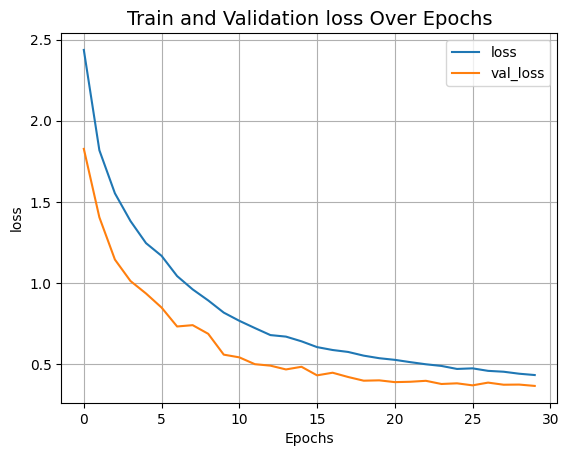

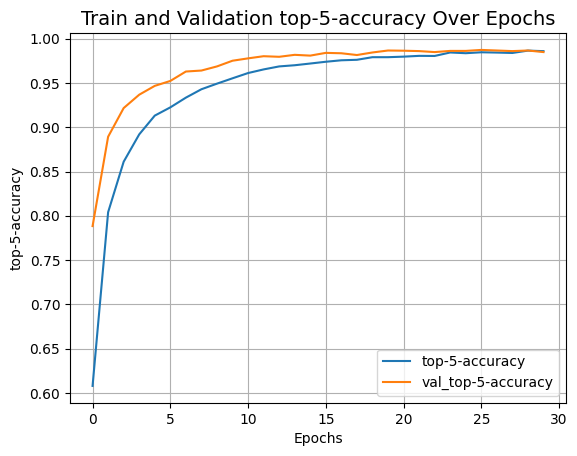

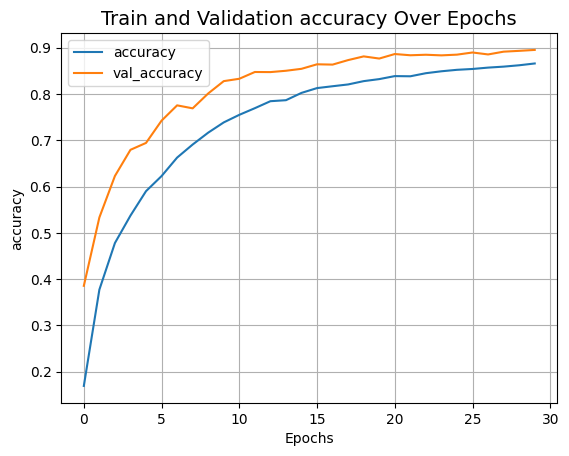

In [46]:
plot_history("loss")
plot_history("top-5-accuracy")
plot_history("accuracy")


# 5. Evaluation
Just like in previous notebook, we're gonna do simple evaluation using built-in evaluate function. After that we're gonna calculate confusion matrix using function from tf.math module.

In [15]:
# if we just wanna evaluate existing model, we can start here
vit_classifier = keras.saving.load_model("svhn_transformer.keras")

/home/nikola/envs/tf2keras3/lib/python3.10/site-packages/keras/src/layers/layer.py:396: UserWarning: `build()` was called on layer 'shifted_patch_tokenization_6', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/home/nikola/envs/tf2keras3/lib/python3.10/site-packages/keras/src/layers/layer.py:396: UserWarning: `build()` was called on layer 'patch_encoder_6', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [16]:
print("Evaluate on test data")
results = vit_classifier.evaluate(val_ds, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data


I0000 00:00:1746688863.064666   37593 cuda_dnn.cc:529] Loaded cuDNN version 90600


71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.8923 - loss: 0.3691 - top-5-accuracy: 0.9860
test loss, test acc: [0.36622390151023865, 0.8952740430831909, 0.9849123358726501]


In [20]:
# get predictions
y_pred = vit_classifier.predict(val_ds, verbose=2)

y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in val_ds:
   # append true labels
   y_true.append(label_batch)

correct_labels = tf.concat([item for item in y_true], axis = 0)
# calculate confusion matrix
confusion = tf.math.confusion_matrix(
              labels = correct_labels,      # get true labels 
              predictions = np.argmax(y_pred, axis=1),  # get predicted labels 
              num_classes=10)

print(confusion)

71/71 - 3s - 41ms/step
tf.Tensor(
[[ 28  59  45  41  33  33  21  29  23  22]
 [ 70 158 111  82  77  79  84  63  50  49]
 [ 49 115  88  77  58  53  58  34  38  37]
 [ 41  89  57  64  64  42  49  49  27  43]
 [ 36  80  59  53  47  45  38  27  26  28]
 [ 39  75  51  66  41  28  32  28  29  25]
 [ 30  68  52  59  39  24  37  12  32  24]
 [ 26  54  55  44  30  20  20  36  29  29]
 [ 17  64  45  42  31  27  24  29  29  24]
 [ 18  60  49  35  32  26  25  26  29  13]], shape=(10, 10), dtype=int32)


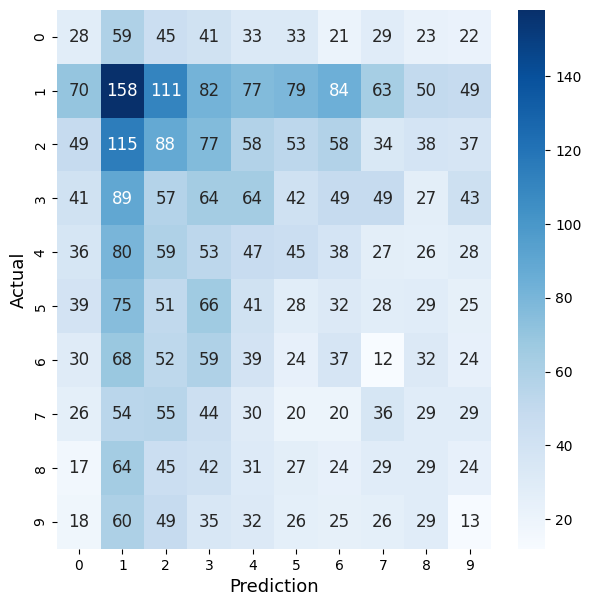

In [21]:
# Visualize confusion matrix
cm = pd.DataFrame(confusion.numpy(), # convert to array
               range(10),range(10))

plt.figure(figsize = (7, 7))
matrix_plot = sns.heatmap(cm, annot=True, annot_kws={"size": 12}, fmt='d', xticklabels=val_ds.class_names,
            yticklabels=val_ds.class_names, cmap='Blues')
plt.xlabel('Prediction', fontsize=13)
plt.ylabel('Actual', fontsize=13)

fig = matrix_plot.get_figure()
fig.savefig('confusion_matrix.png', format='png', facecolor='white', dpi=150, bbox_inches='tight')
plt.show()

<Axes: xlabel='Labels', ylabel='Counts'>

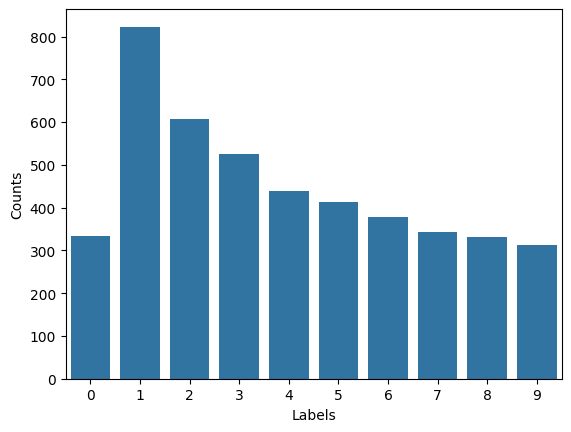

In [24]:
labels = []
for x, y in val_ds:
  labels.append(y)

labels = np.concatenate(labels, axis = 0)

counts = np.zeros(10, dtype=np.int32)
for l in labels:
    counts[l] += 1

plt.ylabel('Counts')
plt.xlabel('Labels')
sns.barplot(x = [0,1,2,3,4,5,6,7,8,9], y = counts) 